OBJECTIVE: BUILD A CLASSIFIER FOR NEWS: FALSE OR TRUE

In [113]:
# libraries importation

    # to load data
    
    import pandas as pd
    import numpy as np
    
    # to clean data

    import re
    import string
    import nltk
    from nltk import sent_tokenize, word_tokenize
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords
    from nltk.probability import FreqDist
    from nltk.corpus import names

    # to visualize and explore data

    import matplotlib.pyplot as plt
    %matplotlib inline
    import itertools
    import plotly
    from wordcloud import WordCloud
    
    # to make train / test split
    import random
    from sklearn.model_selection import train_test_split
    
    # to vectorize text
    
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.feature_extraction.text import HashingVectorizer
    
    # to classify news
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.linear_model import PassiveAggressiveClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import LinearSVC
    
    # to measuere our classification
    
    import sklearn.metrics 
    from sklearn.metrics import accuracy_score
    
    # to save model
    
    import pickle
    
    







LOADING THE DATASET: NEWS (you can see the dataset building process in the next jupyter notebool:
                          news_scraping.ipynb, in the same directory as the actual)

In [2]:
news = pd.read_csv('./data/news_dataset.csv', index_col=0)

EXPLORATORY DATA ANALYSIS

In [3]:
# Exploring the dataset.
news.head()

,author,body,h1,h2,label,url
0,NaN,Ojalá una bomba ahora en Colón. ¿Donde están l...,"Pablo Iglesias borra un tuit: ""Ojalá una bomb...",NaN,False,http://elmetropolitanodemadrid.blogspot.com/20...
1,TransMurcia,En una comparecencia digna del Club de la Come...,El Partido Popular acapara el 86% del coste po...,NaN,False,http://murciatransparente.net/partido-popular-...
2,NaN,"Según informa el digital El Cadenazo, la alcal...",Manuela Carmena se ha convertido recientemente...,NaN,False,http://www.12minutos.com/5c255a4e64b9a/manuela...
3,NaN,Si en nuestra última noticia anunciábamos la p...,NUEVO RADAR DE TRAFICO INVISIBLE. COMPÁRTELO!,Llega a España el radar ‘invisible’. Tráfico p...,False,http://www.aldeaviral.com/nuevo-radar-de-trafi...
4,Miguel Ruiz,"El líder del PP dice que ""haré lo posible para...",Pablo Casado: haré lo posible para impedir que...,NaN,False,http://viraladvertising.over-blog.com/2018/11/...


How is our dataframe?

In [4]:
news.shape

(762, 6)

Look at the variables and their types

In [5]:
news.dtypes

author    object
body      object
h1        object
h2        object
label       bool
url       object
dtype: object

Identify the columns with missing values.

In [6]:
null_cols = news.isnull().sum()
null_cols


author     32
body        9
h1          3
h2        185
label       0
url         0
dtype: int64

In [7]:
# We "correct" the nulls value, adding the word 'empty'

news = news.fillna('empty')

In [8]:
# Looking for null columns again: 
null_cols = news.isnull().sum()
null_cols

author    0
body      0
h1        0
h2        0
label     0
url       0
dtype: int64

FEATURE CREATION


We build two new columns:

    - new_structure
    - body length

    new_structure:      value 1 (if the new has the traditional strcture: headline, subheadline, 
                                 body and author) or 
                        value 0 (if there is an 'empty' value in one of these columns).

    body length:        the length of the new's body in number of character. 

In [9]:
# body_length creation

news['bodylength'] = [len(x) for x in news['body']]

In [10]:
# Numeric statistic description of bodylength as our unique numeric column 

news.bodylength.describe()

count      762.000000
mean      3284.653543
std       2356.264174
min          5.000000
25%       1482.250000
50%       2723.000000
75%       4457.250000
max      17834.000000
Name: bodylength, dtype: float64

In [16]:

# new_structure = [0 for row in news if news.isin({'Author': ['empty'], 'h1': ['empty'], 'h2': ['empty'], 'body': ['empty']}) else 1]

news['new_structure'] = (news == 'empty').any(axis=1)
news['new_structure'] = np.where((news['new_structure']== True), 0,1)

In [17]:
# How news looks like after the change
news.head()

,author,body,h1,h2,label,url,bodylength,new_structure
0,empty,Ojalá una bomba ahora en Colón. ¿Donde están l...,"Pablo Iglesias borra un tuit: ""Ojalá una bomb...",empty,False,http://elmetropolitanodemadrid.blogspot.com/20...,84,0
1,TransMurcia,En una comparecencia digna del Club de la Come...,El Partido Popular acapara el 86% del coste po...,empty,False,http://murciatransparente.net/partido-popular-...,2294,0
2,empty,"Según informa el digital El Cadenazo, la alcal...",Manuela Carmena se ha convertido recientemente...,empty,False,http://www.12minutos.com/5c255a4e64b9a/manuela...,777,0
3,empty,Si en nuestra última noticia anunciábamos la p...,NUEVO RADAR DE TRAFICO INVISIBLE. COMPÁRTELO!,Llega a España el radar ‘invisible’. Tráfico p...,False,http://www.aldeaviral.com/nuevo-radar-de-trafi...,1133,0
4,Miguel Ruiz,"El líder del PP dice que ""haré lo posible para...",Pablo Casado: haré lo posible para impedir que...,empty,False,http://viraladvertising.over-blog.com/2018/11/...,564,0


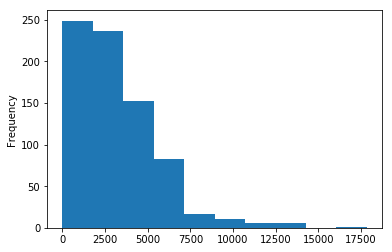

In [35]:
# The distribution of body length

news['bodylength'].plot(kind='hist')

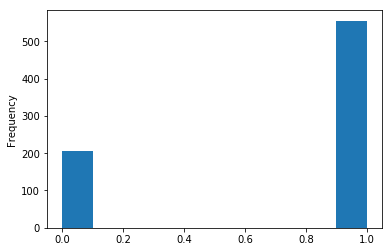

In [49]:
# The distribution of traditional structure in the body of the newsbody length

news['new_structure'].plot(kind='hist')

In [68]:
# How much false news has not the the traditional structure? How much true news?

len((news[(news['label'] == False) & (news['new_structure'] == 0)]))

181

In [ ]:
# How much true news?

In [69]:
len((news[(news['label'] == True) & (news['new_structure'] == 0)]))

26

In [70]:
# Has te same length false and true news?
news.groupby('label').agg({'bodylength': 'mean'})

,bodylength
label,
False,1820.377863
True,4051.934000


Preparing Text Data For Analysis

functions for cleaning, tokenizing, stemming and lemmatizing data and for deleting stop words

In [71]:
# function for cleaning

def clean_up_text(text):
    """
    The function cleans up numbers, remove punctuation and line break, and special characters from a string 
    and converts it to lowercase.

    Args:
        text: The string to be cleaned up.

    Returns:
        A string that has been cleaned up.
    """
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text) 
    text = re.sub('\w*\d\w*', '', text)    
    text = re.sub('[‘’“”…«»¿?¡!\-_\(\)]', '', text)
    text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text)
  
    return text



In [72]:
# function for tokenizing

def tokenize_text(text):
        """
        Tokenize a string.

        Args:
            text: String to be tokenized.

        Returns:
            A list of words as the result of tokenization.
        """
        return word_tokenize(text)


In [73]:
# function for stemming, and lemmatizing

def stem_and_lemmatize(list_of_words):
    """
    Perform stemming and lemmatization on a list of words.

    Args:
        list_of_words: A list of strings.

    Returns:
        A list of strings after being stemmed and lemmatized.
    """
    stemmer = nltk.stem.SnowballStemmer('spanish')
    lemmatizer = WordNetLemmatizer()
    stemmed_lemmantized_list = [stemmer.stem(lemmatizer.lemmatize(word)) for word in list_of_words]
    return stemmed_lemmantized_list

In [74]:
# function for stops words

def remove_stopwords(list_of_words):
    """
    Remove English stopwords from a list of strings.

    Args:
        list_of_words: A list of strings.

    Returns:
        A list of strings after stop words are removed.
    """
    spanish_stop_words = stopwords.words('spanish')
      
    return [w for w in list_of_words if not w in spanish_stop_words]


Executing cleaning, tokenizing, stemming, lemmatizing and deleting stop words functions

In [75]:
# Cleaning
news['processed_body'] = news['body'].apply(lambda x: clean_up_text(str(x)))

In [76]:
# Stemming
news['processed_body'] = news['processed_body'].apply(tokenize_text)

In [77]:
# Lemmatizing
news['processed_body'] = news['processed_body'].apply(stem_and_lemmatize)

In [78]:
# Removing stop words
news['processed_body'] = news['processed_body'].apply(remove_stopwords)

In [79]:
# Visualizing the dataset
news.head()

,author,body,h1,h2,label,url,bodylength,new_structure,processed_body
0,empty,Ojalá una bomba ahora en Colón. ¿Donde están l...,"Pablo Iglesias borra un tuit: ""Ojalá una bomb...",empty,False,http://elmetropolitanodemadrid.blogspot.com/20...,84,0,"[ojal, bomb, ahor, colon, dond, estan, terror,..."
1,TransMurcia,En una comparecencia digna del Club de la Come...,El Partido Popular acapara el 86% del coste po...,empty,False,http://murciatransparente.net/partido-popular-...,2294,0,"[comparecent, dign, club, comedi, rafael, hern..."
2,empty,"Según informa el digital El Cadenazo, la alcal...",Manuela Carmena se ha convertido recientemente...,empty,False,http://www.12minutos.com/5c255a4e64b9a/manuela...,777,0,"[segun, inform, digital, cadenaz, alcaldes, ma..."
3,empty,Si en nuestra última noticia anunciábamos la p...,NUEVO RADAR DE TRAFICO INVISIBLE. COMPÁRTELO!,Llega a España el radar ‘invisible’. Tráfico p...,False,http://www.aldeaviral.com/nuevo-radar-de-trafi...,1133,0,"[si, nuestr, ultim, notici, anunci, propuest, ..."
4,Miguel Ruiz,"El líder del PP dice que ""haré lo posible para...",Pablo Casado: haré lo posible para impedir que...,empty,False,http://viraladvertising.over-blog.com/2018/11/...,564,0,"[lid, pp, dic, har, posibl, par, imped, salari..."


VISUAL ANALYSIS OF THE CORPUS (news['body'])

Wordcloud of the corpus(word frequency visualization. The size of the word in the image is bigger for more frequent word and smaller for less frequent word):

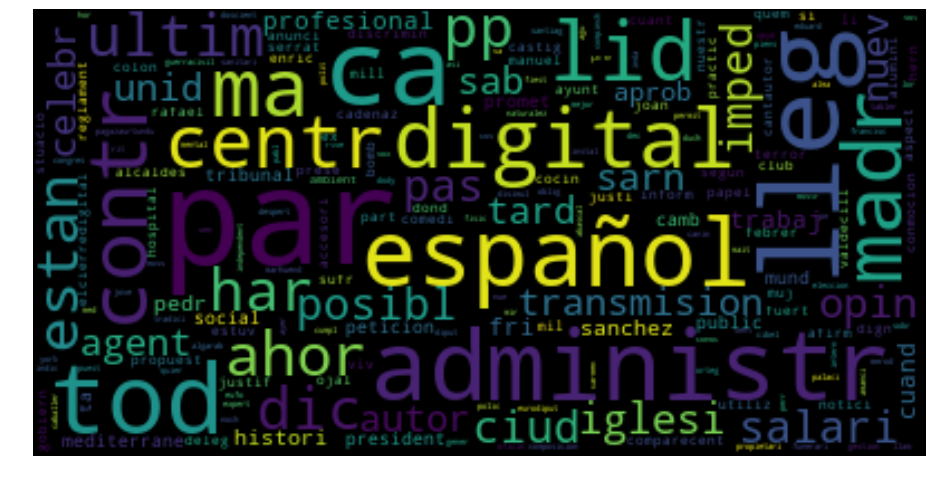

In [96]:
text = ''.join(x for x in str(news['processed_body']))
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [117]:
word

'[\'Ojalá una bomba ahora en Colón. ¿Donde están los Terroristas cuando se les necesita?\', \'En una comparecencia digna del Club de la Comedia Rafael Hernando aseguró que la propuesta de moción de censura de Podemos era, en realidad, “un invento de Pablo Iglesias para desviar la atención de su chalet”. Como el Club de la Comedia pero sin puta gracia, claro: las evidencias de que España lleva años gobernada por una organización criminal con el nombre de Partido Popular es abrumadora, como acaba de rubricar la sentencia de la Audiencia Nacional sobre la Trama Gürtel, verdadera obra de ingeniería del saqueo de los facinerosos.\\n\\nAntes de que alguno diga aquello de “son todos iguales”, equiparando mendazmente el saqueo de los fondos públicos con la (torpe e impropia) hipoteca millonaria de Pablo e Irene, conviene recordar unos cuantos datos que lleva recopilando desde hace años la web Casos Aislados:\\n\\n1. El Partido Popular copa el 86% del coste de los 387 “casos aislados” de corrup

Frequency distribution plot 

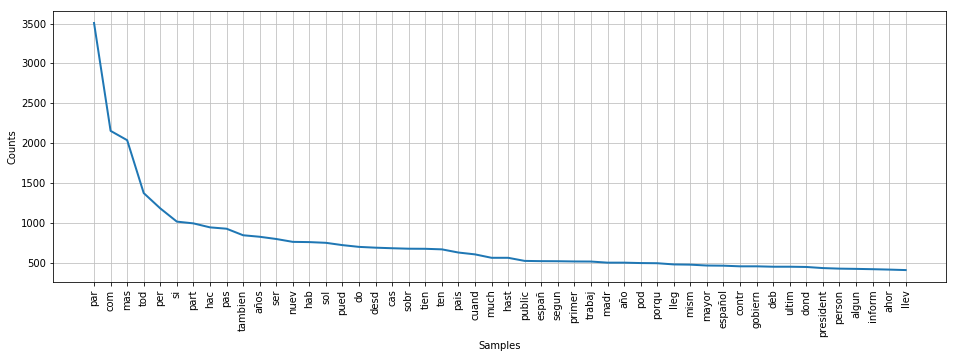

In [132]:

freqdist = nltk.FreqDist(word)
plt.figure(figsize=(16,5))
freqdist.plot(50)

In [131]:
# Frequency distribution plot of words by topic

topics = ['gobierno', 'inmigración', 'podemos', 'vox','ministro','pedro', 'prohibición']
word = news['processed_body'].sum()
freqdist = FreqDist(word)
for topic in topics:

    # print 5 most frequent words
    print(topic,'more :', ' , '.join([ word.lower() for word, count in freqdist.most_common(5)]))
    # print 5 least frequent words
    print(topic,'less :', ' , '.join([ word.lower() for word, count in freqdist.most_common()[-5:]]))
    


gobierno more : par , com , mas , tod , per
gobierno less : toxoalbumin , peoni , calaver , exsuegr , manriqu
inmigración more : par , com , mas , tod , per
inmigración less : toxoalbumin , peoni , calaver , exsuegr , manriqu
podemos more : par , com , mas , tod , per
podemos less : toxoalbumin , peoni , calaver , exsuegr , manriqu
vox more : par , com , mas , tod , per
vox less : toxoalbumin , peoni , calaver , exsuegr , manriqu
ministro more : par , com , mas , tod , per
ministro less : toxoalbumin , peoni , calaver , exsuegr , manriqu
pedro more : par , com , mas , tod , per
pedro less : toxoalbumin , peoni , calaver , exsuegr , manriqu
prohibición more : par , com , mas , tod , per
prohibición less : toxoalbumin , peoni , calaver , exsuegr , manriqu


CREATING MODEL FOR CLASSIFICATION

In the next cells we will build various models for news classification between fake or real news.

For this task, we will combine differente ways of processing text (vectorizer) with various classifiers.

Vectorizers: 

-ad hoc tokenization, stemming and lemmatization.

-vectorization by three different models: (TFIDF vectorizer, Countvectorizer and HashingVectorizer).

Classifiers: 
- Nltk.NaiveBayes.
- MultinomialNB
- PassiveAggresive.
- LogisticRegression.
- LinearSVC

So, we will test (by accuracy and confusion matrix) the next mixes of vectorizer and classficator:

1. Ad hoc + nltk.naivebayes
2. TFIDF + multinomialNB
3. Countvectorizer + multinomialNB.
4. TFIDF + PassiveAggresive.
5. HashingVectorizer + multinomialNB
6. HashingVectorizer + PassiveAggresive.
7. Countvectorizer + LogisticRegression.
8. TFIDF + LogisticRegression.
9. Countvectorizer + LinearSVC.
10. Countvectorizer + LinearSVC with 3 ngrams.

Finally, we will choose the mix with better combination.

1. Ad hoc + nltk.naivebayes


Ad hoc tokenization, stemming and lemmatization:

Creating Bag of Words.
 The bag of words contains all the unique words in your whole text body

In [144]:
# Creating a bag of words from the processed data.


bag_of_words = []
for word in news.processed_body:
    bag_of_words += word



Building Features

    Using the top 5,000 words, we create a diccionary to record whether each of those words is    
    contained in each document (new's text). 
    Nest to the dicctionary, we add the label is True o False.
    So, we get a set with a dictionary and the label.

In [145]:
# Selecting the most important words to build the features with NLTK's FreqDist

# Calling Freqdist()

fdist = FreqDist(bag_of_words)


# Selecting the top 5,000 words from the frequency distribution with most_common().

selected = fdist.most_common(10000)

top_words = [x[0] for x in selected]


In [146]:
# Function to generate the features and label tuple.

def find_features(text_of_new, label):
    words = set(text_of_new)
    features = {}
    for w in top_words:
        features[w] = (w in words)
    result = label
    return (features, result)

In [147]:
# find_features() execution on news' text

features = list(news.apply(lambda x: find_features(x['processed_body'], x['label']), axis=1))


#Accuracy with the original dataset (only 60 false news + 60 true news)

train_set, test_set = features[:48] + features[60:108], features[48:60] + features[108:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, test_set))*100)
Classifier accuracy percent: 58.333333333333336


#train_set, test_set = features[:48] + features[60:108], features[48:60] + features[108:]

    # 209 y 53 falsas, 400 y 100 verdaderas
    # train_set = 209 falsas y 400 verdaderas
    # test_set = 53 falsas y 100 verdaderas

X, y = features[:][0], features[:][1]
features_true = [feature for feature in features if feature[1] == True]
features_false = [feature for feature in features if feature[1] == False]


In [151]:
#train_set, test_set = random.sample(features_true, 50) + random.sample(features_false, 183), 
#random.sample(the_list, 50) + random.sample(the_list, 50) 


random.shuffle(features_true)
random.shuffle(features_false)

train_set, test_set = features_true[:400] + features_false[:209], features_true[400:] + features_false[209:]


In [152]:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, test_set))*100)


Classifier accuracy percent: 86.27450980392157


In [153]:
#testing = test_set[0][0]
true_labels = []
predicted_labels = []
for element in test_set:
    true_labels.append(element[1])
    predicted_labels.append(classifier.classify(element[0]))
confusion_df = pd.DataFrame({'True_label': true_labels,'Predicted_label': predicted_labels})


In [154]:
cm = nltk.ConfusionMatrix(true_labels, predicted_labels)
print(cm)

      |  F    |
      |  a  T |
      |  l  r |
      |  s  u |
      |  e  e |
------+-------+
False |<48> 5 |
 True | 16<84>|
------+-------+
(row = reference; col = test)



In [273]:
# Defining true positives, false positives and false negatives
TP = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [274]:
#Precision, which indicates how many of the items that we identified were relevant, is TP/(TP+FP).
precision = TP/(TP+FP)
print('Preccision: ', precision) 

#Recall, which indicates how many of the relevant items that we identified, is TP/(TP+FN).
recall = TP/(TP+FN)
print('Recall: ', recall) 

#The F-Measure (or F-Score), which combines the precision and recall to give a single score, 
#is defined to be the harmonic mean of the precision and recall: 
#(2 × Precision × Recall) / (Precision + Recall).
f_score= (2 * precision * recall) / (precision + recall)
print('F-score: ', f_score)


Preccision:  0.8918918918918919
Recall:  0.66
F-score:  0.7586206896551725


In [155]:
# Showing the most informative features for this model.
classifier.show_most_informative_features()

Most Informative Features
                     abc = True             True : False  =     13.8 : 1.0
                 mantien = True             True : False  =     12.7 : 1.0
                   anunc = True             True : False  =     12.4 : 1.0
                       € = True            False : True   =     12.1 : 1.0
                 complej = True             True : False  =     10.3 : 1.0
                  fallec = True             True : False  =     10.0 : 1.0
                   entid = True             True : False  =      9.6 : 1.0
                   cierr = True             True : False  =      9.3 : 1.0
                pendient = True             True : False  =      9.3 : 1.0
                   ambit = True             True : False  =      8.9 : 1.0


NEW MODELS

In [4]:
I

In [277]:
# features to dataframe

In [278]:
# Extracting the training data
X_train, X_test, y_train, y_test = train_test_split((news['body'].apply(lambda x: clean_up_text(str(x)))), news['label'], test_size=0.33, random_state=53)


Building Vectorizer Classifiers

In [279]:
null_cols = news.isnull().sum()
null_cols
news = news.fillna('vacío')

author             32
body                9
h1                  3
h2                185
label               0
url                 0
processed_body      0
dtype: int64

In [280]:
news = news.fillna('vacío')

In [5]:
# Spanish stop_words

spanish = ['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las','por','un',
'para','con','no','una','su','al','lo','como','más','pero','sus','le','ya','o','este','sí','porque''esta','entre','cuando','muy','sin','sobre',
'también','me','hasta','hay','donde','quien','desde','todo','nos','durante','todos','uno','les','ni','contra',
'otros','ese','eso','ante','ellos','e','esto','mí','antes','algunos','qué','unos','yo','otro',
'otras','otra','él','tanto','esa','estos','mucho','quienes','nada','muchos','cual','poco','ella','estar',
'estas','algunas','algo','nosotros','mi','mis','tú','te','ti','tu','tus','ellas','nosotras',
'vosostros','vosostras','os','mío','mía','míos','mías','tuyo','tuya','tuyos','tuyas','suyo','suya','suyos',
'suyas','nuestro','nuestra','nuestros','nuestras','vuestro','vuestra','vuestros','vuestras','esos','esas','estoy',
'estás','está','estamos','estáis','están','esté','estés','estemos','estéis','estén','estaré','estarás',
'estará','estaremos','estaréis','estarán','estaría','estarías',
'estaríamos','estaríais','estarían','estaba','estabas','estábamos','estabais','estaban','estuve','estuviste','estuvo','estuvimos',
'estuvisteis','estuvieron','estuviera','estuvieras','estuviéramos','estuvierais','estuvieran','estuviese','estuvieses',
'estuviésemos','estuvieseis','estuviesen','estando','estado','estada','estados',
'estadas','estad','he','has','ha','hemos','habéis','han','haya','hayas','hayamos','hayáis','hayan',
'habré','habrás','habrá','habremos','habréis','habrán','habría','habrías','habríamos','habríais',
'habrían','había','habías','habíamos','habíais','habían','hube','hubiste','hubo','hubimos','hubisteis',
'hubieron','hubiera','hubieras','hubiéramos','hubierais','hubieran','hubiese','hubieses','hubiésemos',
'hubieseis','hubiesen','habiendo','habido','habida','habidos','habidas','soy','eres','es','somos','sois',
'son','sea','seas','seamos','seáis','sean','seré','serás','será','seremos','seréis','serán','sería',
'serías','seríamos','seríais','serían','era','eras','éramos','erais','eran','fui','fuiste','fue','fuimos',
'fuisteis','fueron','fuera','fueras','fuéramos','fuerais','fueran','fuese','fueses','fuésemos','fueseis',
'fuesen','sintiendo','sentido','sentida','sentidos','sentidas','siente','sentid','tengo','tienes',
'tiene','tenemos','tenéis','tienen','tenga','tengas','tengamos','tengáis','tengan','tendré',
'tendrás','tendrá','tendremos','tendréis','tendrán','tendría','tendrías','tendríamos',
'tendríais','tendrían','tenía','tenías','teníamos','teníais','tenían','tuve','tuviste','tuvo','tuvimos',
'tuvisteis','tuvieron','tuviera','tuvieras','tuviéramos','tuvierais','tuvieran','tuviese','tuvieses',
'tuviésemos','tuvieseis','tuviesen','teniendo','tenido','tenida','tenidos','tenidas','tened']



In [282]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words=spanish)


In [283]:
# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

In [284]:
# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [285]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words=spanish, max_df=0.7) 


In [286]:
# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

In [287]:
# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [288]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])

['única', 'únicamente', 'únicas', 'únicla', 'único', 'únicos', 'úsalo', 'útero', 'útil', 'útiles']


In [289]:
# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

['aalbersberg', 'ab', 'abadía', 'abajo', 'abanca', 'abanderados', 'abandona', 'abandonada', 'abandonadas', 'abandonado']


Count versus TF-IDF Features

In [290]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())



In [291]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())



In [292]:
difference = set(count_df.columns) - set(tfidf_df.columns)




In [293]:
print(count_df.equals(tfidf_df))



False


In [294]:
count_df.head()

,aalbersberg,ab,abadía,abajo,abanca,abanderados,abandona,abandonada,abandonadas,abandonado,...,única,únicamente,únicas,únicla,único,únicos,úsalo,útero,útil,útiles
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [295]:
'label' in count_df.columns
count_df.label.value_counts()
count_df[count_df.label == 20]
news.iloc[405].body, news.iloc[405].label

("Abertis ha lanzado a primera hora de este lunes una emisión de bonos con la que confía colocar títulos de deuda por un importe máximo de hasta 3.000 millones de euros y con vencimientos a cinco, siete y doce años, según informaron a Europa Press en fuentes del mercado.Se trata de la mayor emisión de deuda de entre las realizadas por Abertis y una de las mayores corporativas lanzadas hasta ahora por compañías españolas. Los bonos se emiten en euros, con un plazo de amortización de cinco y siete años, pero también en libras, en este caso a doce años, según dichas fuentes.La operación se enmarca en el programa de emisión de deuda por hasta 7.000 millones de euros que la compañía de autopistas controlada por ACS y Atlantia registró en la Bolsa de Irlanda a comienzos de mes.Abertis destinará los fondos que capte con la titulización a reestructurar parte de su pasivo. En concreto, refinanciará un tramo de los tres en los que se dividió el crédito que el grupo preside Florentino Pérez y la 

In [296]:
count_df.head()

,aalbersberg,ab,abadía,abajo,abanca,abanderados,abandona,abandonada,abandonadas,abandonado,...,única,únicamente,únicas,únicla,único,únicos,úsalo,útero,útil,útiles
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [297]:
tfidf_df.head()

,aalbersberg,ab,abadía,abajo,abanca,abanderados,abandona,abandonada,abandonadas,abandonado,...,única,únicamente,únicas,únicla,único,únicos,úsalo,útero,útil,útiles
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.032205,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.035274,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


Comparing Models (train and test your models.)

In [298]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy:   0.659
Confusion matrix, without normalization


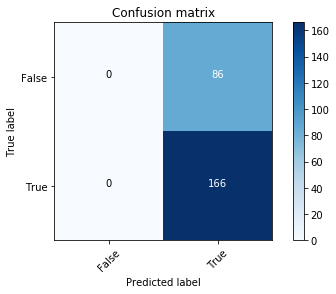

In [299]:
# tfidfvectorizer + multinomialNB

clf = MultinomialNB() 


clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

accuracy:   0.790
Confusion matrix, without normalization


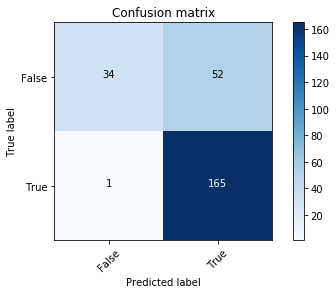

In [300]:
# Countvectorizer + multinomialNB
clf = MultinomialNB() 

clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

Testing Linear Models (use a SVM)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy:   0.833
Confusion matrix, without normalization


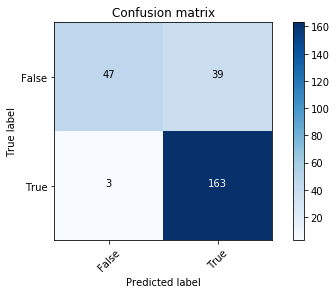

In [301]:
# tfidfvectorizer + PassiveAggressive

linear_clf = PassiveAggressiveClassifier(n_iter=50)
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

test if tuning the alpha value for a MultinomialNB:

In [302]:
clf = MultinomialNB(alpha=0.1)

last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = sklearn.metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

    clf = MultinomialNB(alpha=0.1)

last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = sklearn.metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

Alpha: 0.00 Score: 0.72619
Alpha: 0.10 Score: 0.80159
Alpha: 0.20 Score: 0.71032
Alpha: 0.30 Score: 0.69048
Alpha: 0.40 Score: 0.68254
Alpha: 0.50 Score: 0.67857
Alpha: 0.60 Score: 0.67460
Alpha: 0.70 Score: 0.66667
Alpha: 0.80 Score: 0.66667
Alpha: 0.90 Score: 0.66270
Alpha: 0.00 Score: 0.72619
Alpha: 0.10 Score: 0.80159
Alpha: 0.20 Score: 0.71032
Alpha: 0.30 Score: 0.69048
Alpha: 0.40 Score: 0.68254
Alpha: 0.50 Score: 0.67857
Alpha: 0.60 Score: 0.67460
Alpha: 0.70 Score: 0.66667
Alpha: 0.80 Score: 0.66667
Alpha: 0.90 Score: 0.66270


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Introspecting models

In [303]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)

In [304]:
most_informative_feature_for_binary_classification(tfidf_vectorizer, linear_clf, n=30)


False -1.4916232516708754 iglesias
False -1.270609188021632 inmigrantes
False -1.0679860015343798 podemos
False -1.0527981511629991 presos
False -1.0339132298409297 español
False -0.9969528085420672 cabo
False -0.9942723569762728 iglesia
False -0.9832259608981586 jugadores
False -0.979470739104658 gatorade
False -0.9282171620434315 real
False -0.9265684085097338 españoles
False -0.8897452966421612 concurso
False -0.8641493499492078 canción
False -0.8395331980474985 documental
False -0.8388533242948389 marroquíes
False -0.8386986249700579 florentino
False -0.8383733951494708 ayudas
False -0.8287033107485053 llevan
False -0.819091677548425 ayuntamiento
False -0.798090914632284 sanidad
False -0.794932064783271 vox
False -0.784473068850723 comida
False -0.7806144782779726 dem
False -0.7728964144967347 mujer
False -0.7529956834388422 noche
False -0.7505165599172197 tobillos
False -0.7494048023764236 pelo
False -0.7409390747992906 pues
False -0.7397307641982946 pedro
False -0.737474106261286

zipping coefficients to  features and taking a look at the top and bottom of your list:


In [305]:
feature_names = tfidf_vectorizer.get_feature_names()

In [306]:
### Most real
sorted(zip(clf.coef_[0], feature_names), reverse=True)[:20]

[(-8.238432851475594, 'años'),
 (-8.397769083892129, 'dos'),
 (-8.406687976294052, 'si'),
 (-8.495951450682584, 'esta'),
 (-8.56662432283884, 'millones'),
 (-8.590947153350701, 'presidente'),
 (-8.625977841457033, 'gobierno'),
 (-8.629815370489615, 'españa'),
 (-8.63239430012026, 'porque'),
 (-8.637681198137656, 'año'),
 (-8.638119663431887, 'según'),
 (-8.643133370195525, 'pasado'),
 (-8.643990147613568, 'país'),
 (-8.65755104192289, 'parte'),
 (-8.657643201650625, 'tras'),
 (-8.65853358954905, 'madrid'),
 (-8.69584825118156, 'hace'),
 (-8.739926501765886, 'ser'),
 (-8.742410728454091, 'después'),
 (-8.744056695152782, 'solo')]

In [307]:
### Most fake
sorted(zip(clf.coef_[0], feature_names))[:20]

[(-10.368754638525337, 'abandonará'),
 (-10.368754638525337, 'abandone'),
 (-10.368754638525337, 'abaratarán'),
 (-10.368754638525337, 'abasto'),
 (-10.368754638525337, 'abdelhafid'),
 (-10.368754638525337, 'abdelkrim'),
 (-10.368754638525337, 'abducidas'),
 (-10.368754638525337, 'aberrantes'),
 (-10.368754638525337, 'abochornante'),
 (-10.368754638525337, 'abogó'),
 (-10.368754638525337, 'abolida'),
 (-10.368754638525337, 'abolido'),
 (-10.368754638525337, 'abona'),
 (-10.368754638525337, 'abonado'),
 (-10.368754638525337, 'abortos'),
 (-10.368754638525337, 'abracen'),
 (-10.368754638525337, 'abraham'),
 (-10.368754638525337, 'abrazos'),
 (-10.368754638525337, 'abriré'),
 (-10.368754638525337, 'abrumadora')]

In [308]:
 #extract the full list from your current classifier 

tokens_with_weights = sorted(list(zip(feature_names, clf.coef_[0])))


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


accuracy:   0.683
Confusion matrix, without normalization


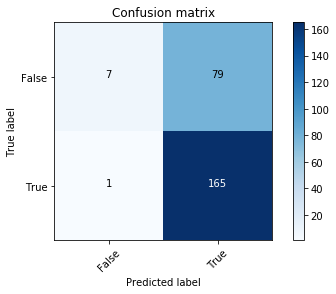

In [309]:
 ##Hashvectorizer + Multinomial


hash_vectorizer = HashingVectorizer(stop_words=spanish, non_negative=True)

hash_train = hash_vectorizer.fit_transform(X_train)
hash_test = hash_vectorizer.transform(X_test)
clf = MultinomialNB(alpha=.01)
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy:   0.861
Confusion matrix, without normalization


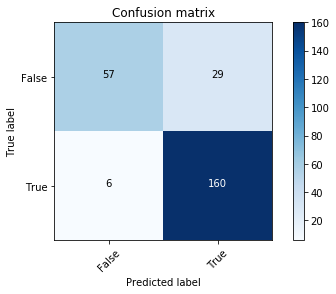

In [310]:
# Another test:

# HashVectorizer + passive_aggressive

clf = PassiveAggressiveClassifier(n_iter=50)
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

In [311]:

# 1. CountVectorizer and logistic regression.
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = ngram_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = ngram_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, lr.predict(X_test))))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.8733031674208145
Accuracy for C=0.05: 0.9095022624434389
Accuracy for C=0.25: 0.9004524886877828
Accuracy for C=0.5: 0.9004524886877828
Accuracy for C=1: 0.9004524886877828


In [312]:
final_ngram = LogisticRegression(C=1) 
final_ngram.fit(X_train, y_train)
print ("Final Accuracy: %s" % accuracy_score(y_test, final_ngram.predict(X_test)))

Final Accuracy: 0.9004524886877828


accuracy:   0.900
Confusion matrix, without normalization


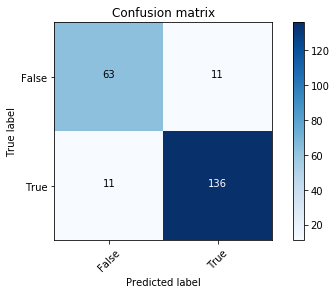

In [313]:

pred = lr.predict(X_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

In [314]:
# 2. Tfidf + logistic regression
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = tfidf_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = tfidf_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))

Accuracy for C=0.01: 0.6742081447963801
Accuracy for C=0.05: 0.6742081447963801
Accuracy for C=0.25: 0.6877828054298643
Accuracy for C=0.5: 0.7194570135746606
Accuracy for C=1: 0.7963800904977375


In [315]:
final_tfidf = LogisticRegression(C=1)
final_tfidf.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_tfidf.predict(X_test)))

Final Accuracy: 0.7963800904977375


accuracy:   0.796
Confusion matrix, without normalization


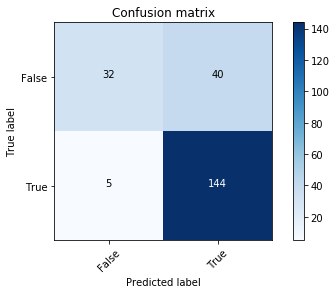

In [316]:
pred = lr.predict(X_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

In [9]:
# 3. CountVectorizer and LinearSVC

ngram_vectorizer = CountVectorizer(stop_words=spanish, binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = ngram_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = ngram_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, svm.predict(X_test))))

Accuracy for C=0.01: 0.8959276018099548
Accuracy for C=0.05: 0.8914027149321267
Accuracy for C=0.25: 0.8914027149321267
Accuracy for C=0.5: 0.8914027149321267
Accuracy for C=1: 0.8914027149321267


In [7]:
final_svm_ngram = LinearSVC(C=0.05)
final_svm_ngram.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_svm_ngram.predict(X_test)))

Final Accuracy: 0.8914027149321267


accuracy:   0.860
Confusion matrix, without normalization


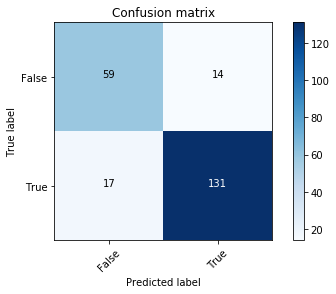

In [319]:
pred = final_svm_ngram.predict(X_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

In [27]:
# Count + SVC + n_gram_range: 3

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
ngram_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = ngram_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = ngram_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.001, 0.005, 0.01, 0.05, 0.1,0.5,1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, svm.predict(X_test))))

Accuracy for C=0.001: 0.8371040723981901
Accuracy for C=0.005: 0.832579185520362
Accuracy for C=0.01: 0.8280542986425339
Accuracy for C=0.05: 0.8190045248868778
Accuracy for C=0.1: 0.8190045248868778
Accuracy for C=0.5: 0.8190045248868778
Accuracy for C=1: 0.8190045248868778


In [12]:
final = LinearSVC(C=0.005)
final.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final.predict(X_test)))

Final Accuracy: 0.8868778280542986


In [16]:
# save the model to disk

filename = 'finalized_model.sav'
pickle.dump(svm, open(filename, 'wb'))

In [ ]:
# Loading the model
'''
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
'''

In [33]:
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
ngram_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))

#X_test = ngram_vectorizer.transform(sentencesTest)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [34]:
filename2 = 'finalized_vectorizer.sav'
pickle.dump(ngram_vectorizer, open(filename2, 'wb'))

In [30]:
X_test[2]

<1x536865 sparse matrix of type '<class 'numpy.int64'>'
	with 2039 stored elements in Compressed Sparse Row format>

In [29]:
# one new prediction
display(svm.predict())
y_test[3]

348     True
175     True
499     True
489     True
42     False
730    False
323     True
640    False
156     True
259     True
130     True
647    False
146     True
25     False
141     True
461     True
76      True
346     True
442     True
143     True
186     True
134     True
161     True
723    False
485     True
430     True
490     True
339     True
406     True
106     True
       ...  
579    False
21     False
750    False
619    False
148     True
710    False
484     True
292     True
377     True
20     False
524     True
151     True
724    False
620    False
711    False
88      True
381     True
197     True
688    False
334     True
734    False
744    False
238     True
301     True
416     True
251     True
714    False
464     True
418     True
108     True
Name: label, Length: 221, dtype: bool

accuracy:   0.905
Confusion matrix, without normalization


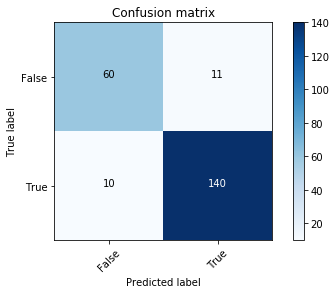

In [152]:
pred = final.predict(X_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

Comprar todos los modelos con acccuracy y confusion matrix.
Mejorar los elegidos añadiendo features: estrutura y longitud de body.

COMPROBRACIÓN DE VECTORIZACIÓN AD HOC vs VECTORIZER CON EL MODELO ELEGIDO

In [186]:
hand_features = [feature[0] for feature in features]
hand_vector_features = pd.DataFrame(hand_features)
hand_vector_features
vector_hand = hand_vector_features * 1
vector_hand.head()


,aalbersberg,abaj,abal,aban,abander,abandon,abarat,abarc,abarrot,abascal,...,—qu,—si,—supuest,—un,—y,—ya,€,,﻿bon,﻿codig
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [189]:
X = vector_hand
X_train, X_test, y_train, y_test = train_test_split(X, news['label'], train_size = 0.71)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [190]:
for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, svm.predict(X_test))))

Accuracy for C=0.001: 0.8235294117647058
Accuracy for C=0.005: 0.8914027149321267
Accuracy for C=0.01: 0.8823529411764706
Accuracy for C=0.05: 0.8823529411764706
Accuracy for C=0.1: 0.8778280542986425


AÑADIMOS ESTRUTURA Y LONGITUD DE TEXTO COMO FEATURE

In [202]:
news['bodylength'] = [len(x) for x in news.body]


,author,body,h1,h2,label,url,processed_body,bodylength
0,vacío,Ojalá una bomba ahora en Colón. ¿Donde están l...,"Pablo Iglesias borra un tuit: ""Ojalá una bomb...",vacío,False,http://elmetropolitanodemadrid.blogspot.com/20...,"[ojal, bomb, ahor, colon, dond, estan, terror,...",84
1,TransMurcia,En una comparecencia digna del Club de la Come...,El Partido Popular acapara el 86% del coste po...,vacío,False,http://murciatransparente.net/partido-popular-...,"[comparecent, dign, club, comedi, rafael, hern...",2294
2,vacío,"Según informa el digital El Cadenazo, la alcal...",Manuela Carmena se ha convertido recientemente...,vacío,False,http://www.12minutos.com/5c255a4e64b9a/manuela...,"[segun, inform, digital, cadenaz, alcaldes, ma...",777
3,vacío,Si en nuestra última noticia anunciábamos la p...,NUEVO RADAR DE TRAFICO INVISIBLE. COMPÁRTELO!,Llega a España el radar ‘invisible’. Tráfico p...,False,http://www.aldeaviral.com/nuevo-radar-de-trafi...,"[si, nuestr, ultim, notici, anunci, propuest, ...",1133
4,Miguel Ruiz,"El líder del PP dice que ""haré lo posible para...",Pablo Casado: haré lo posible para impedir que...,vacío,False,http://viraladvertising.over-blog.com/2018/11/...,"[lid, pp, dic, har, posibl, par, imped, salari...",564


nan

In [227]:
# Count + SVC + n_gram_range: 3 + features bodystructure and body length

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
ngram_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = ngram_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = ngram_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, svm.predict(X_test))))

TypeError: no supported conversion for types: (dtype('O'), dtype('int64'))